In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlexC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = "cuda"
!nvidia-smi

Tue Jan 31 09:11:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P2    57W / 250W |    448MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def get_workouts():
    urls = [f"https://github.com/cluffa/crossfit-workouts/raw/main/data/{year}.csv" for year in range(2002, 2023)]
    urls.append("https://github.com/cluffa/crossfit-workouts/raw/main/data/wc.csv")
    dfs = [pd.read_csv(url) for url in urls]
    df = pd.concat(dfs, ignore_index = True)
    ws = df.text.copy()
    ws = [w.replace("<|newline|>", "\n") for w in ws]

    return ws

In [5]:
def get_posts():
    urls = [f"https://github.com/cluffa/crossfit-workouts/raw/main/cff/data/wl{i}.csv" for i in range(1, 5)]
    dfs = [pd.read_csv(url) for url in urls]
    df = pd.concat(dfs, ignore_index = True)
    ws = df.text.copy()
    ws = [str(w).replace("<|newline|>", "\n") for w in ws]

    return ws

In [6]:
def text_info(text):
    doc_lengths = []

    for t in text:

        # get rough token count distribution
        tokens = nltk.word_tokenize(t)

        doc_lengths.append(len(tokens))

    doc_lengths = np.array(doc_lengths)

    print(f"percent longer than max: {len(doc_lengths[doc_lengths > 256])/len(doc_lengths)}\n")
    print(f"average length: {np.average(doc_lengths)}\n")

    return sns.histplot(doc_lengths)

In [7]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=256):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [8]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
def make_dataset(text, batch_size = 8):
    dataset = GPT2Dataset(text, tokenizer, max_length=256)

    # Split into training and validation sets
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

    validation_dataloader = DataLoader(
        val_dataset, # The validation samples.
        sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
        batch_size = batch_size # Evaluate with this batch size.
    )

    return train_dataloader, validation_dataloader

In [10]:
def new_model(device = device):
    configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

    model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

    model.resize_token_embeddings(len(tokenizer))

    device = torch.device(device)
    model.to(device)

    return model

In [11]:
def train_model(
    model,
    train_dataloader,
    validation_dataloader,
    epochs = 13,
    learning_rate = 5e-5,
    warmup_steps = 1e2,
    epsilon = 1e-8,
    sample_every = 250
    ):

    optimizer = AdamW(
        model.parameters(),
        lr = learning_rate,
        eps = epsilon
    )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = warmup_steps, 
        num_training_steps = total_steps
    )

    def format_time(elapsed):
        return str(datetime.timedelta(seconds=int(round((elapsed)))))
        
    total_t0 = time.time()

    training_stats = []

    model = model.to(device)

    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)

            model.zero_grad()        

            outputs = model(  b_input_ids,
                            labels=b_labels, 
                            attention_mask = b_masks,
                            token_type_ids=None
                            )

            loss = outputs[0]  

            batch_loss = loss.item()
            total_train_loss += batch_loss

            # Get sample every x batches.
            if step % sample_every == 0 and not step == 0:

                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

                # model.eval()

                # sample_outputs = model.generate(
                #                         bos_token_id=random.randint(1,30000),
                #                         do_sample=True,   
                #                         top_k=50, 
                #                         max_length = 200,
                #                         top_p=0.95, 
                #                         num_return_sequences=1
                #                     )
                # for i, sample_output in enumerate(sample_outputs):
                #       print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
                
                # model.train()

            loss.backward()

            optimizer.step()

            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)       
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)
            
            with torch.no_grad():        

                outputs  = model(b_input_ids, 
    #                            token_type_ids=None, 
                                attention_mask = b_masks,
                                labels=b_labels)
            
                loss = outputs[0]  
                
            batch_loss = loss.item()
            total_eval_loss += batch_loss        

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        validation_time = format_time(time.time() - t0)    

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')

    return df_stats

In [12]:
def plot_df_stats(df_stats):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    #plt.xticks([1, 2, 3, 4])

    plt.show()

In [13]:
model = new_model()

In [14]:
train_dl_posts, validation_dl_posts = make_dataset(get_posts())

KeyboardInterrupt: 

In [15]:
df1_stats = train_model(
    model,
    train_dl_posts,
    validation_dl_posts,
    epochs = 3,
    learning_rate = 5e-4
)
df1_stats


======== Epoch 1 / 3 ========
Training...


c:\Users\AlexC\workspace\GitFit\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch   250  of  41,977. Loss: 1.7474874258041382.   Elapsed: 0:01:14.
  Batch   500  of  41,977. Loss: 1.4630128145217896.   Elapsed: 0:02:25.
  Batch   750  of  41,977. Loss: 2.559157371520996.   Elapsed: 0:03:36.
  Batch 1,000  of  41,977. Loss: 1.487130880355835.   Elapsed: 0:04:47.
  Batch 1,250  of  41,977. Loss: 2.1272671222686768.   Elapsed: 0:05:58.
  Batch 1,500  of  41,977. Loss: 1.4918032884597778.   Elapsed: 0:07:09.
  Batch 1,750  of  41,977. Loss: 1.532501220703125.   Elapsed: 0:08:20.
  Batch 2,000  of  41,977. Loss: 1.4952787160873413.   Elapsed: 0:09:31.
  Batch 2,250  of  41,977. Loss: 1.9671794176101685.   Elapsed: 0:10:42.
  Batch 2,500  of  41,977. Loss: 1.7475236654281616.   Elapsed: 0:11:53.
  Batch 2,750  of  41,977. Loss: 1.5715651512145996.   Elapsed: 0:13:04.
  Batch 3,000  of  41,977. Loss: 1.8128265142440796.   Elapsed: 0:14:15.
  Batch 3,250  of  41,977. Loss: 0.8610239028930664.   Elapsed: 0:15:26.
  Batch 3,500  of  41,977. Loss: 1.3776100873947144.  

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.372114,1.248191,3:21:35,0:07:04
2,1.208066,1.178274,3:21:58,0:07:03
3,1.107443,1.145403,3:21:56,0:07:04


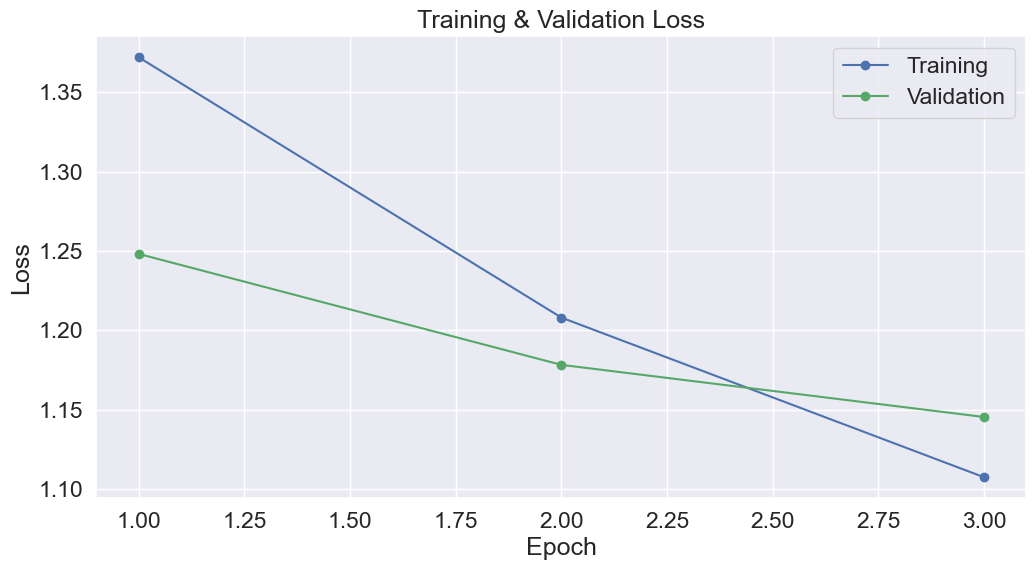

In [16]:
plot_df_stats(df1_stats)

In [16]:
train_dl_workouts, validation_dl_workouts = make_dataset(get_workouts())

5,662 training samples
  630 validation samples


In [17]:
df2_stats = train_model(
    model,
    train_dl_workouts,
    validation_dl_workouts,
    epochs = 10,
    learning_rate = 5e-6
)
df2_stats

c:\Users\AlexC\workspace\GitFit\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 10 ========
Training...
  Batch   250  of    708. Loss: 0.5948335528373718.   Elapsed: 0:01:23.
  Batch   500  of    708. Loss: 0.6184139251708984.   Elapsed: 0:02:44.

  Average training loss: 0.34
  Training epoch took: 0:03:52

Running Validation...
  Validation Loss: 0.30
  Validation took: 0:00:08

======== Epoch 2 / 10 ========
Training...
  Batch   250  of    708. Loss: 0.22456419467926025.   Elapsed: 0:01:22.
  Batch   500  of    708. Loss: 0.7235013246536255.   Elapsed: 0:02:44.

  Average training loss: 0.30
  Training epoch took: 0:03:52

Running Validation...
  Validation Loss: 0.29
  Validation took: 0:00:08

======== Epoch 3 / 10 ========
Training...
  Batch   250  of    708. Loss: 0.1600465476512909.   Elapsed: 0:01:22.
  Batch   500  of    708. Loss: 0.1817248910665512.   Elapsed: 0:02:44.

  Average training loss: 0.29
  Training epoch took: 0:03:52

Running Validation...
  Validation Loss: 0.28
  Validation took: 0:00:08

======== Epoch 4 / 10 ====

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.335827,0.301260,0:03:52,0:00:08
2,0.304753,0.285847,0:03:52,0:00:08
3,0.290905,0.277369,0:03:52,0:00:08
4,0.282308,0.272192,0:03:45,0:00:07
5,0.276104,0.268430,0:03:20,0:00:07
6,0.271616,0.265881,0:03:21,0:00:07
7,0.268183,0.264101,0:03:20,0:00:07
8,0.265911,0.262837,0:03:20,0:00:07
9,0.264203,0.262177,0:03:20,0:00:07


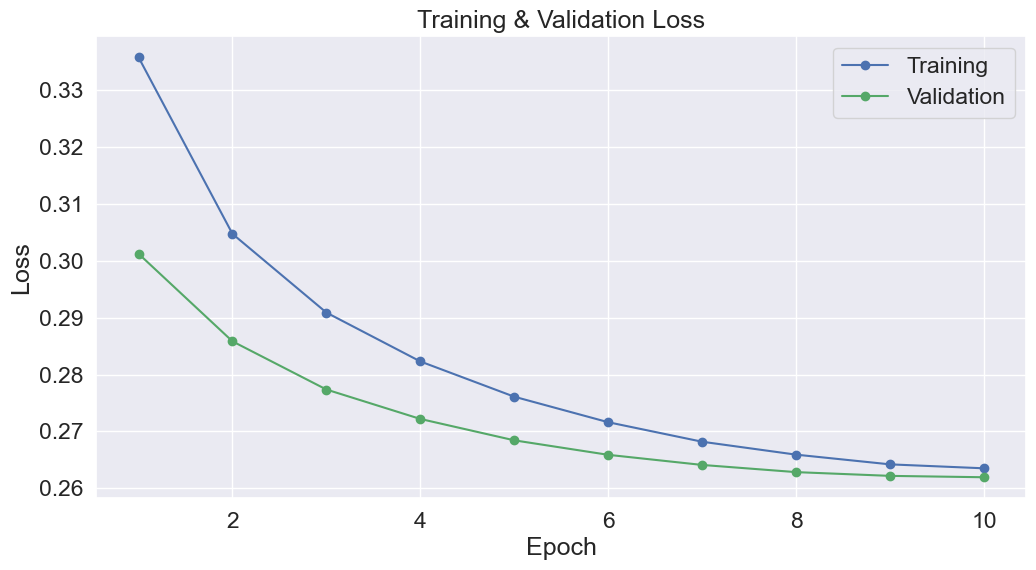

In [18]:
plot_df_stats(df2_stats)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [21]:
output_dir = './gitfit-model/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./gitfit-model/


('./gitfit-model/tokenizer_config.json',
 './gitfit-model/special_tokens_map.json',
 './gitfit-model/vocab.json',
 './gitfit-model/merges.txt',
 './gitfit-model/added_tokens.json')

In [20]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

#print(generated)

sample_outputs = model.generate(
    generated, 
    #bos_token_id=random.randint(1,30000),
    do_sample=True,   
    top_k=50, 
    max_length = 300,
    top_p=0.95, 
    num_return_sequences=10
)

with open("output.txt", "w", encoding="utf-8") as f:
    for i, sample_output in enumerate(sample_outputs):
        outstr = "---- {} ----\n{}\n\n".format(i+1, tokenizer.decode(sample_output, skip_special_tokens=True))
        outstr = outstr.replace("<|newline|>", "\n")
        f.writelines(outstr)
        print(outstr)
        
model.train()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- 1 ----
"Elizabeth"
21-15-9 reps of:
Clean 135 pounds
Ring dips


---- 2 ----
Complete as many rounds in 12 minutes as you can of:
Handstand push-ups 5 reps
Bench press 135 pounds, 10 reps
Push press 95 pounds, 15 reps
Dips 20 reps


---- 3 ----
3 rounds for time of:
20 box jumps
12 shoulder-to-overheads, 155 lb.
50 double-unders


---- 4 ----
Treadmill - 20 minutes
Distance 5.2 miles
Time 43:28


---- 5 ----
A. Power Clean and Jerk - build to a tough single
B. Front Squat - build to a tough single
C. Push Jerk - build to a tough single
D. Run 1,000 meters


---- 6 ----
Warm-up: Jump rope, sit-ups, push-ups, KB swings, windmills, wall-ball shots, MB cleans
3 rounds for time of:
200 meters Run
30 Wall-ball shots, 20 pound ball
10 Muscle-ups
"This is the CrossFit Journal article in The New York Journal, which is on the fitness forum. But, that is the article. It points out what the author wrote in the article."
- William Starr


---- 7 ----
Snatch balance 1-1-1-1-1-1-1 reps


---- 8 

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [14]:
output_dir = './gitfit-model-cp1/'
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro